In [ ]:
import nltk
nltk.download('stopwords')

from collections import defaultdict
from array import array
import time
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#elimina emojis del texto
def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # Emojis in Emoticons
                           u"\U0001F300-\U0001F5FF"  # Emojis in Miscellaneous Symbols and Pictographs
                           u"\U0001F680-\U0001F6FF"  # Emojis in Transport and Map Symbols
                           u"\U0001F700-\U0001F77F"  # Emojis in Alphabetic Presentation Forms
                           u"\U0001F780-\U0001F7FF"  # Emojis in Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Emojis in Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Emojis in Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Emojis in Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Emojis in Symbols and Pictographs Extended-A
                           u"\U0001F004-\U0001F0CF"  # Mahjong Tiles
                           u"\U0001F170-\U0001F251"  # Emojis in Enclosed Alphanumeric Supplement
                           "]+", flags=re.UNICODE)

    # Remove emojis from the text
    return emoji_pattern.sub(r'', text)

In [ ]:
#Extraemos la informacion total del tweet
def extract_tweet_info(tweet):
    tweet_id = tweet.get("id_str", "N/A")
    tweet_text = tweet.get("full_text", "N/A")
    created_at = tweet.get("created_at", "N/A")
    hashtags = ", ".join([ht["text"] for ht in tweet.get("entities", {}).get("hashtags", [])])
    likes = tweet.get("favorite_count", 0)
    retweets = tweet.get("retweet_count", 0)
    url = f"https://twitter.com/{tweet['user']['screen_name']}/status/{tweet['id_str']}"


    return [tweet_id, tweet_text, created_at, hashtags, likes, retweets, url]



In [ ]:
#formatted_tweet tendra los tweets de Rus_Ukr_war_data.json
docs_path = 'Rus_Ukr_war_data.json'
formatted_tweets = []
with open(docs_path, 'r') as fp:
    for line in fp:
        try:
            tweet_data = json.loads(line)
            formatted_tweet = extract_tweet_info(tweet_data)
            formatted_tweets.append(formatted_tweet)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

In [ ]:
#Numero total de tweets
len(formatted_tweets)

4000

In [ ]:
#Tweet de ejemplo
formatted_tweets[2]

['1575917992390823936',
 'ALERT 🚨Poland preps anti-radiation tablets over nuclear threat\n\n#NATO #Putin #Russia #RussiaInvadedUkraine #Ukraine #UkraineRussiaWar',
 'Fri Sep 30 18:38:23 +0000 2022',
 'NATO, Putin, Russia, RussiaInvadedUkraine, Ukraine, UkraineRussiaWar',
 0,
 0,
 'https://twitter.com/NEWS_ALL_TIME/status/1575917992390823936']

In [ ]:
def build_terms(line):
    """
    Preprocess the article text (title + body) removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.

    Argument:
    line -- string (text) to be preprocessed

    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    line=  line.lower() ## Transform in lowercase
    line=  remove_emojis(line)
    line=  line.split() ## Tokenize the text to get a list of terms
    line= [x for x in line if x not in stop_words]  ##eliminate the stopwords (HINT: use List Comprehension)
    line= [stemmer.stem(x) for x in line] ## perform stemming (HINT: use List Comprehension)

    return line

In [ ]:
tweets_relevant = []
for t in formatted_tweets:
    relevant_info = []
    relevant_info.append(t[0])
    relevant_info.append(build_terms(t[1]))
    tweets_relevant.append(relevant_info)

'''for t in tweets_relevant:
  for w in t[-1]:
      if "#" in w and w[1:] not in t:
          t[-1].append(w[1:])'''

'for t in tweets_relevant:\n  for w in t[-1]:\n      if "#" in w and w[1:] not in t:\n          t[-1].append(w[1:])'

In [ ]:
print(formatted_tweets[2])
print(tweets_relevant[2])

#formated tweet: Tweet |Date | Hashtags | Likes | Retweets | Url | relevantwords

['1575917992390823936', 'ALERT 🚨Poland preps anti-radiation tablets over nuclear threat\n\n#NATO #Putin #Russia #RussiaInvadedUkraine #Ukraine #UkraineRussiaWar', 'Fri Sep 30 18:38:23 +0000 2022', 'NATO, Putin, Russia, RussiaInvadedUkraine, Ukraine, UkraineRussiaWar', 0, 0, 'https://twitter.com/NEWS_ALL_TIME/status/1575917992390823936']
['1575917992390823936', ['alert', 'poland', 'prep', 'anti-radi', 'tablet', 'nuclear', 'threat', '#nato', '#putin', '#russia', '#russiainvadedukrain', '#ukrain', '#ukrainerussiawar']]


In [ ]:
def create_index(lines):
    """
    Implement the inverted index

    Argument:
    lines -- collection of Wikipedia articles

    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of documents where these keys appears in (and the positions) as values.
    """
    index = defaultdict(list)

    for line_arr in lines:  # Remember, lines contain all documents: article-id | article-title | article-body

        page_id = int(line_arr[0])
        terms = line_arr[1] # page_title + page_text
        relevant_words = line_arr[1]

        ## ===============================================================
        ## create the index for the current page and store it in current_page_index (current_page_index)
        ## current_page_index ==> { ‘term1’: [current_doc, [list of positions]], ...,‘term_n’: [current_doc, [list of positions]]}

        ## Example: if the curr_doc has id 1 and his text is
        ##"web retrieval information retrieval":

        ## current_page_index ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}

        ## the term ‘web’ appears in document 1 in positions 0,
        ## the term ‘retrieval’ appears in document 1 in positions 1 and 4
        ## ===============================================================

        current_page_index = {}

        for position, term in enumerate(terms): # terms contains page_title + page_text. Loop over all terms
            try:
                # if the term is already in the index for the current page (current_page_index)
                # append the position to the corresponding list


                current_page_index[term][page_id].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term]=[page_id, array('I',[position])] #'I' indicates unsigned int (int in Python)

        #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)



    return index

In [ ]:
create_index(tweets_relevant)


defaultdict(list,
            {'@melsimmonsfcdo': [[1575918221013979136, array('I', [0])]],
             'wrong.': [[1575918221013979136, array('I', [1])],
              [1575159725859418112, array('I', [8])]],
             'dictat': [[1575918221013979136, array('I', [2])],
              [1575897910075850752, array('I', [2])],
              [1575894237807140867, array('I', [1])],
              [1575891486180114442, array('I', [6])],
              [1575826594513330178, array('I', [9])],
              [1575623030776045568, array('I', [1])]],
             "putin'": [[1575918221013979136, array('I', [3])],
              [1575911251393142784, array('I', [1])],
              [1575908078352039936, array('I', [3])],
              [1575905170952982529, array('I', [1])],
              [1575904570542542848, array('I', [1])],
              [1575899185202724868, array('I', [5])],
              [1575898687808540672, array('I', [3])],
              [1575890992615813120, array('I', [0])],
            

In [ ]:
index = create_index(tweets_relevant)

In [ ]:
docs_path = 'Rus_Ukr_war_data_ids.csv'
with open(docs_path) as fp:
    csvlines = fp.readlines()


resultado_diccionarios = {}
for linea in csvlines:
    partes = linea.strip().split('\t')
    if len(partes) == 2:
        resultado_diccionarios[partes[0]] = partes[1]

print(resultado_diccionarios)

{'doc_1': '1575918221013979136', 'doc_2': '1575918081461080065', 'doc_3': '1575917992390823936', 'doc_4': '1575917907774967809', 'doc_5': '1575917878410301441', 'doc_6': '1575917759707299841', 'doc_7': '1575917751360593920', 'doc_8': '1575917748978434053', 'doc_9': '1575917670049857538', 'doc_10': '1575917624298307585', 'doc_11': '1575916840286507009', 'doc_12': '1575916494990417920', 'doc_13': '1575916461620690977', 'doc_14': '1575916233102217217', 'doc_15': '1575915883385409537', 'doc_16': '1575915806319427621', 'doc_17': '1575915601012281344', 'doc_18': '1575915581278420992', 'doc_19': '1575915545869750272', 'doc_20': '1575915251169574912', 'doc_21': '1575915211336605698', 'doc_22': '1575915151890399232', 'doc_23': '1575914957362712576', 'doc_24': '1575914711388139520', 'doc_25': '1575914586791763968', 'doc_26': '1575914563886727169', 'doc_27': '1575914279295156224', 'doc_28': '1575914207052283925', 'doc_29': '1575914059031101452', 'doc_30': '1575913989195718657', 'doc_31': '1575913

## **Punto 2**

In [ ]:
#word counting distribution
def procesar_diccionario(diccionario):
    salida = []
    for clave in list(diccionario.keys()):
        entrada = clave
        num_elementos_lista = len(diccionario[clave])
        salida.append([entrada, num_elementos_lista])
    return salida
repeticiones_palabras = procesar_diccionario(index)
print(repeticiones_palabras)

[['@melsimmonsfcdo', 1], ['wrong.', 2], ['dictat', 6], ["putin'", 61], ['fascist', 8], ['russia', 369], ['intend', 5], ['conquer', 2], ['much', 26], ['ukrainian', 418], ['land', 51], ['possible.', 4], ['#russiainvadesukrain', 6], ['#ukrainerussiawar', 3841], ['❤️', 8], ['arm', 102], ['forc', 237], ['liber', 44], ['villag', 12], ['#drobyshev', 5], ['#lymansk', 1], ['urban', 2], ['territori', 122], ['commun', 13], ['#donetsk', 85], ['region.#ukrainerussiawar', 1], ['#ukrainewar', 1220], ['#ukraine️', 233], ['#ukrainewillwin', 177], ['#ukrainianarmi', 173], ['#ukrainecounteroffens', 93], ['#ukrainewarnew', 254], ['#slavaukraïni', 60], ['#standwithukrain', 233], ['https://t.co/ifg0rxdmbq', 1], ['alert', 7], ['poland', 13], ['prep', 1], ['anti-radi', 1], ['tablet', 1], ['nuclear', 98], ['threat', 28], ['#nato', 437], ['#putin', 500], ['#russia', 1169], ['#russiainvadedukrain', 172], ['#ukrain', 1971], ['i’m', 8], ['still', 34], ['wait', 19], ['googl', 1], ['map', 21], ['️', 25], ['updat', 2

In [ ]:
def sentence_length(tweets):
    salida = []
    for tweet in tweets:
        salida.append(len(tweet[1]))
    print(tweets[np.argmax(salida)])
    return salida
length_all_sentences = sentence_length(tweets_relevant)
print(length_all_sentences)

['1575506012836093953', ['@emmamashford', '@soonergrunt', '@canadanato', '@canadafp', '@cafinukrain', '@canembukrain', '@whnsc', '@usembassykyiv', '@stephenwalt', '@cbcchrisbrown', '@grayconnolli', '@lawdavf', '@navalhistorian', '@wethebrandon', '@justinmassie1', '@jdcushman', '@osc', '@usosc', '@nato', '@lievenanatol', '@ralee85', '@briarstewart', '@drradchenko', '@cafreeland', '@melaniejoli', '@20committe', '@ereguli', '@anitaanandmp', '@milnews_ca', '@efpbglatvia', '@adam_tooz', '@stevenchas', '@ameliairheart', '@mrfrantarelli', '@kaptainloma', '@cfoper', '@murray_brewst', '@nukestrat', '@caf_colleg', '@cafineurop', '@nationaldef', '@privycouncilca', '@markmackinnon', '@janicedickson', '@hrw', '@unicef', '@crisisgroup', '#russianukrainianwar:', '@mattgurney', 'think', 'previous', 'unthink', 'thing', 'https://t.co/vfegtsubvh', '#putin', '#russia', '#ukrainerussiawar', '#russianarmi', '#ukrain', '#nato', '#nuclearweapon', '#cdnfp']]
[14, 21, 13, 18, 13, 19, 18, 19, 16, 12, 9, 25, 27, 

In [ ]:
# Crear un histograma
plt.hist(length_all_sentences, bins=30, edgecolor='black', alpha=0.7)  # Puedes ajustar el número de "bins" según tu preferencia

# Agregar etiquetas y título
plt.xlabel('Palabras Relevantes')
plt.ylabel('Frecuencia')
plt.title('Palabras relevantes en los tweets')

# Mostrar el histograma
plt.show()

In [ ]:
#Total number or words
print(len(index.keys()))

16573


In [ ]:
#most liked tweets
formatted_tweets
def most_liked_tweets(formatted_tweets, N_top):
  formatted_tweets = sorted(formatted_tweets, key=lambda x: x[-3],reverse=True)
  return formatted_tweets[:N_top]
most_liked_tweets(formatted_tweets,3)


[['1575775162674212865',
  '🗺️Situation around Lyman - Sep 30 11:00:\n- UA forces liberated Yampil and advancing north\n- RU troops are reportedly abandoning its positions in Drobysheve\n- The only exit route from Lyman is within the firing range of UA forces\n#UkraineRussiaWar https://t.co/jGJUhXcr1y',
  'Fri Sep 30 09:10:49 +0000 2022',
  'UkraineRussiaWar',
  3701,
  646,
  'https://twitter.com/Militarylandnet/status/1575775162674212865'],
 ['1575396903252025351',
  "📷Unique and rare photos of Ukrainian forward command post during the offensive in #Kharkiv Oblast. News reporters aren't usually invited to such places, but here seems to be an exception.\n#UkraineRussiaWar https://t.co/AmSijyM59c",
  'Thu Sep 29 08:07:45 +0000 2022',
  'Kharkiv, UkraineRussiaWar',
  2685,
  338,
  'https://twitter.com/Militarylandnet/status/1575396903252025351'],
 ['1575181552170201088',
  '📽️Operation Interflex: Ukrainian recruits continue to master their skills under the guidance of British and Canad

In [ ]:
#most retweeted tweets
formatted_tweets
def most_retweeted_tweets(formatted_tweets, N_top):
  formatted_tweets = sorted(formatted_tweets, key=lambda x: x[-2],reverse=True)
  return formatted_tweets[:N_top]
most_retweeted_tweets(formatted_tweets,3)

[['1575775162674212865',
  '🗺️Situation around Lyman - Sep 30 11:00:\n- UA forces liberated Yampil and advancing north\n- RU troops are reportedly abandoning its positions in Drobysheve\n- The only exit route from Lyman is within the firing range of UA forces\n#UkraineRussiaWar https://t.co/jGJUhXcr1y',
  'Fri Sep 30 09:10:49 +0000 2022',
  'UkraineRussiaWar',
  3701,
  646,
  'https://twitter.com/Militarylandnet/status/1575775162674212865'],
 ['1575396903252025351',
  "📷Unique and rare photos of Ukrainian forward command post during the offensive in #Kharkiv Oblast. News reporters aren't usually invited to such places, but here seems to be an exception.\n#UkraineRussiaWar https://t.co/AmSijyM59c",
  'Thu Sep 29 08:07:45 +0000 2022',
  'Kharkiv, UkraineRussiaWar',
  2685,
  338,
  'https://twitter.com/Militarylandnet/status/1575396903252025351'],
 ['1575181552170201088',
  '📽️Operation Interflex: Ukrainian recruits continue to master their skills under the guidance of British and Canad

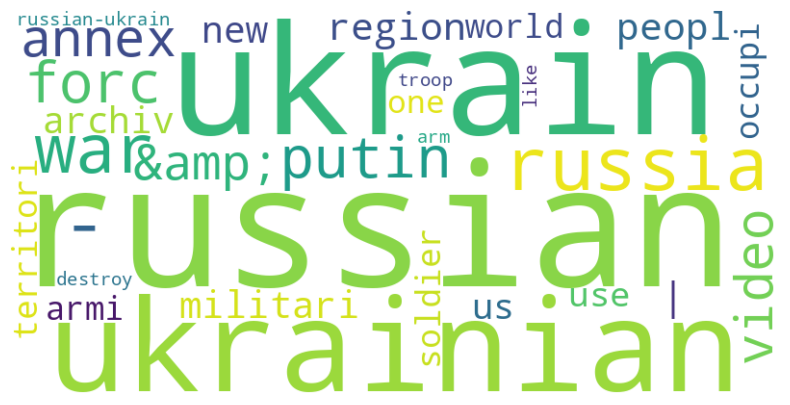

-------------------------------------------------------------------------------------------------------


-------------------------------------------------------------------------------------------------------


In [ ]:

repeticiones_palabras
#mode= nohashtag, hashtag, all
def word_cloud(repeticiones, Ntop = 30, mode = "All"):
  if mode == 'nohashtag':
    repeticiones = [[palabra, frecuencia] for palabra, frecuencia in repeticiones if not palabra.startswith('#')]
  elif mode == 'hashtag':
    repeticiones = [[palabra, frecuencia] for palabra, frecuencia in repeticiones if palabra.startswith('#')]
  top_100_palabras = sorted(repeticiones, key=lambda x: x[1], reverse=True)[:Ntop]
  word_freq = {}
  for palabra, frecuencia in top_100_palabras:
      if palabra in word_freq:
          word_freq[palabra] += frecuencia
      else:
          word_freq[palabra] = frecuencia

  # Crear un objeto WordCloud
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

  # Paso 3: Crear y mostrar la nube de palabras
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()
word_cloud(repeticiones_palabras, 30, 'nohashtag')
print('-------------------------------------------------------------------------------------------------------')
word_cloud(repeticiones_palabras, 30, 'hashtag')
print('-------------------------------------------------------------------------------------------------------')
word_cloud(repeticiones_palabras, 30)

In [ ]:
docs_path = 'Rus_Ukr_war_data_ids.csv'
with open(docs_path) as fp:
    csvlines = fp.readlines()

In [ ]:
print("Total number of Wikipedia articles in the corpus: {}".format(len(csvlines)))

Total number of Wikipedia articles in the corpus: 4000


In [ ]:
csvlines[2]

#toca crear un diccionario entre doc i tweet id
resultado_diccionarios = {}

for linea in csvlines:
    partes = linea.strip().split('\t')
    if len(partes) == 2:
        resultado_diccionarios[partes[0]] = partes[1]

print(resultado_diccionarios)

{'doc_1': '1575918221013979136', 'doc_2': '1575918081461080065', 'doc_3': '1575917992390823936', 'doc_4': '1575917907774967809', 'doc_5': '1575917878410301441', 'doc_6': '1575917759707299841', 'doc_7': '1575917751360593920', 'doc_8': '1575917748978434053', 'doc_9': '1575917670049857538', 'doc_10': '1575917624298307585', 'doc_11': '1575916840286507009', 'doc_12': '1575916494990417920', 'doc_13': '1575916461620690977', 'doc_14': '1575916233102217217', 'doc_15': '1575915883385409537', 'doc_16': '1575915806319427621', 'doc_17': '1575915601012281344', 'doc_18': '1575915581278420992', 'doc_19': '1575915545869750272', 'doc_20': '1575915251169574912', 'doc_21': '1575915211336605698', 'doc_22': '1575915151890399232', 'doc_23': '1575914957362712576', 'doc_24': '1575914711388139520', 'doc_25': '1575914586791763968', 'doc_26': '1575914563886727169', 'doc_27': '1575914279295156224', 'doc_28': '1575914207052283925', 'doc_29': '1575914059031101452', 'doc_30': '1575913989195718657', 'doc_31': '1575913

# EXTRA CODE SIN USAR


In [ ]:
def create_index(lines):
    """
    Implement the inverted index

    Argument:
    lines -- collection of Wikipedia articles

    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of documents where these keys appears in (and the positions) as values.
    """
    index = defaultdict(list)
    title_index = {}  # dictionary to map page titles to page ids
    for line in lines:  # Remember, lines contain all documents: article-id | article-title | article-body
        line_arr = line.split("|")
        page_id = int(line_arr[0])
        terms = build_terms(''.join(line_arr[1:])) # page_title + page_text
        title = line_arr[1]
        title_index[page_id]=title  ## we do not need to apply get terms to title because it used only to print titles and not in the index

        ## ===============================================================
        ## create the index for the current page and store it in current_page_index (current_page_index)
        ## current_page_index ==> { ‘term1’: [current_doc, [list of positions]], ...,‘term_n’: [current_doc, [list of positions]]}

        ## Example: if the curr_doc has id 1 and his text is
        ##"web retrieval information retrieval":

        ## current_page_index ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}

        ## the term ‘web’ appears in document 1 in positions 0,
        ## the term ‘retrieval’ appears in document 1 in positions 1 and 4
        ## ===============================================================

        current_page_index = {}

        for position, term in enumerate(terms): # terms contains page_title + page_text. Loop over all terms
            try:
                # if the term is already in the index for the current page (current_page_index)
                # append the position to the corresponding list

        ## START CODE
                current_page_index[term][page_id].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term]=[page_id, array('I',[position])] #'I' indicates unsigned int (int in Python)

        #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

        ## END CODE

    return index, title_index

In [ ]:
print("Total number of Wikipedia articles in the corpus (jsonlines): {}".format(len(jsonlines)))
print("Total number of Wikipedia articles in the corpus (csvlines): {}".format(len(csvlines)))

Total number of Wikipedia articles in the corpus (jsonlines): 4000
Total number of Wikipedia articles in the corpus (csvlines): 4000


In [ ]:
print(jsonlines[1])
print(csvlines[1])

{"created_at": "Fri Sep 30 18:38:44 +0000 2022", "id": 1575918081461080065, "id_str": "1575918081461080065", "full_text": "\ud83c\uddfa\ud83c\udde6\u2764\ufe0f The Armed Forces liberated the village of #Drobysheve of the #Lymansk urban territorial community in #Donetsk region.#UkraineRussiaWar\n#UkraineWar #Ukraine\ufe0f #UkraineWillWin #UkrainianArmy #ukrainecounteroffensive #UkraineWarNews #SlavaUkra\u00efni #StandWithUkraine https://t.co/ifg0RXDMBQ", "truncated": false, "display_text_range": [0, 265], "entities": {"hashtags": [{"text": "Drobysheve", "indices": [47, 58]}, {"text": "Lymansk", "indices": [66, 74]}, {"text": "Donetsk", "indices": [106, 114]}, {"text": "UkraineRussiaWar", "indices": [122, 139]}, {"text": "UkraineWar", "indices": [140, 151]}, {"text": "Ukraine\ufe0f", "indices": [152, 161]}, {"text": "UkraineWillWin", "indices": [162, 177]}, {"text": "UkrainianArmy", "indices": [178, 192]}, {"text": "ukrainecounteroffensive", "indices": [193, 217]}, {"text": "UkraineWarNe